# ePSproc: auto-gen template development
17/10/19

# Set-up

## Load modules

In [1]:
import sys
import os
import numpy as np

# For module testing, include path to module here, otherwise use global installation
# modPath = r'/home/femtolab/github/ePSproc/'
modPath = r'D:\code\github\ePSproc'
sys.path.append(modPath)
import epsproc as ep

* pyevtk not found, VTK export not available. 


## Load data

In [2]:
# Load data from modPath\data
# TO REPLACE with passed arg, or just use working dir if template copied there.
dataPath = os.path.join(modPath, 'data', 'photoionization')
dataFile = os.path.join(dataPath, 'n2_3sg_0.1-50.1eV_A2.inp.out')  # Set for sample N2 data for testing

In [3]:
# Scan file(s) for various data types...

# For dir scan
# dataXS = ep.readMatEle(fileBase = dataPath, recordType = 'CrossSection')
# dataMatE = ep.readMatEle(fileBase = dataPath, recordType = 'DumpIdy')

# For single file
dataXS = ep.readMatEle(fileIn = dataFile, recordType = 'CrossSection')
dataMatE = ep.readMatEle(fileIn = dataFile, recordType = 'DumpIdy')


*** ePSproc readMatEle(): scanning files for CrossSection segments.

*** Scanning file(s)
['D:\\code\\github\\ePSproc\\data\\photoionization\\n2_3sg_0.1-50.1eV_A2.inp.out']

*** Reading ePS output file:  D:\code\github\ePSproc\data\photoionization\n2_3sg_0.1-50.1eV_A2.inp.out
Expecting 51 energy points.
Expecting 2 symmetries.
Scanning CrossSection segments.
Expecting 3 CrossSection segments.
Found 3 CrossSection segments (sets of results).
Processed 3 sets of CrossSection file segments, (0 blank)
*** ePSproc readMatEle(): scanning files for DumpIdy segments.

*** Scanning file(s)
['D:\\code\\github\\ePSproc\\data\\photoionization\\n2_3sg_0.1-50.1eV_A2.inp.out']

*** Reading ePS output file:  D:\code\github\ePSproc\data\photoionization\n2_3sg_0.1-50.1eV_A2.inp.out
Expecting 51 energy points.
Expecting 2 symmetries.
Scanning CrossSection segments.
Expecting 102 DumpIdy segments.
Found 102 dumpIdy segments (sets of matrix elements).

Processing segments to Xarrays...
Processed 102 sets o

# Job & molecule info

TODO

# 1-photon ePS Cross-Sections
Plot 1-photon cross-sections and $beta_2$ parameters (for an unaligned ensemble) from ePS calculations. These are taken directly from the ePS output file, `CrossSection` segments. See the [ePS manual, `GetCro` command, for further details](https://www.chem.tamu.edu/rgroup/lucchese/ePolyScat.E3.manual/GetCro.html).

## Cross-sections by symmetry & type

Types correspond to:

- 'L': length gauge results.
- 'V': velocity gauge results.
- 'M': mixed gauge results.

Symmetries correspond to allowed ionizing transitions for the molecular point group (IRs typically corresponding to (x,y,z) polarization geometries), see the [ePS manual for a list of symmetries](https://www.chem.tamu.edu/rgroup/lucchese/ePolyScat.E3.manual/SymmetryLabels.html). Symmetry `All` corresponds to the sum over all allowed sets of symmetries.

Cross-section units are MBarn.

In [ ]:
# Plot cross sections using Xarray functionality
# Set here to plot per file - should add some logic to combine files.
for data in dataXS:
    daPlot = data.sel(XC='SIGMA')
    daPlot.plot.line(x='Ehv', col='Type')

## $\beta_{2}$ by symmetry & type

Types & symmetries as per cross-sections.  Normalized $\beta_{2}$ paramters, dimensionless.

In [ ]:
# Repeat for betas
for data in dataXS:
    daPlot = data.sel(XC='BETA')
    daPlot.plot.line(x='Ehv', col='Type')

# Dipole matrix elements
For 1-photon ionization. These are taken directly from ePS `DumpIdy` segments. See the [ePS manual, `DumpIdy` command, for further details](https://www.chem.tamu.edu/rgroup/lucchese/ePolyScat.E3.manual/DumpIdy.html).

In [4]:
# Set threshold for significance, only matrix elements with abs values > thres will be plotted
thres = 1e-3

In [ ]:
# Plot for each fie
for data in dataMatE:
    # Plot only values > theshold
    # daPlot = ep.matEleSelector(data, thres=thres, sq = True)  # element-wise
    daPlot = ep.matEleSelector(data, thres=thres, dims = 'Eke', sq = True)  # element-wise
    
    # Plot abs values, with faceting on symmetry (all mu)
    daPlot.sum('mu').squeeze().pipe(np.abs).plot.line(x='Eke', col='Sym', row='Type')
    
    # Plot phases
    daPlot.data = np.angle(daPlot)
    daPlot.sum('mu').squeeze().plot.line(x='Eke', col='Sym', row='Type')
    

# MFPADs

Calculated MF $\beta$ parameters, using ePS dipole matrix elements. These are calculated by `ep.mfblm()`, as a function of energy and polarization geometry. See [the ePSproc docs on `ep.mfblm()`](https://epsproc.readthedocs.io/en/latest/modules/epsproc.MFBLM.html) for further details, and [this demo notebook](https://epsproc.readthedocs.io/en/latest/ePSproc_BLM_calc_demo_Sept2019_rst/ePSproc_BLM_calc_demo_Sept2019.html).

In [6]:
# Set pol geoms - these correspond to (z,x,y) in molecular frame (relative to principle/symmetry axis)
pRot = [0, 0, np.pi/2]
tRot = [0, np.pi/2, np.pi/2]
cRot = [0, 0, 0]
eAngs = np.array([pRot, tRot, cRot]).T   # List form to use later, rows per set of angles

In [ ]:
# Calculate for each fie & pol geom
# TODO - file logic, and parallelize
BLM = []
for data in dataMatE:
    BLM.append(ep.mfblmEuler(data, selDims = {'Type':'L'}, eAngs = eAngs[angsIn,:], thres = thres, verbose = 0))  # Run for all Eke, selected gauge only

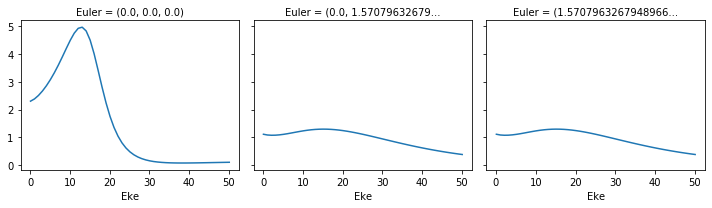

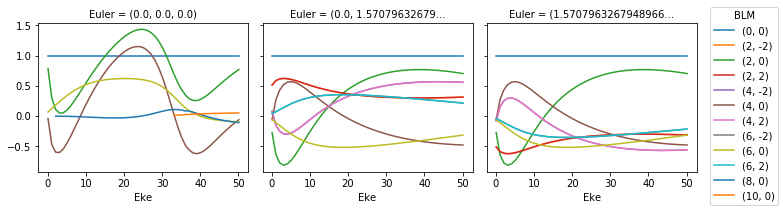

In [9]:
# Normalize and plot results

# Plot unnormalized B00 only, real part
# This is/should be in units of MBarn (TBC).
BLM.where(np.abs(BLM) > thres, drop = True).real.squeeze().sel({'l':0, 'm':0}).plot.line(x='Eke', col='Euler');

# Plot values normalised by B00
# This seems to work... probably a more elegant solution here, since this assumes dimensions.
normBLM = BLM/BLM[:,:,0]
normBLM.where(np.abs(normBLM) > thres, drop = True).real.squeeze().plot.line(x='Eke', col='Euler');

# Error & consistency checks

In [ ]:
# Compare Cross-sections for different types

In [ ]:
# Compare calculated BLMs for L and V types (dafault above for L)

# Calculate for each fie & pol geom
BLMv = []
for data in dataMatE:
    for angsIn in range(0, eAngs.shape[0]):
        # Plot only values > theshold
        BLMv.append(ep.mfblm(data, selDims = {'Type':'V'}, eAngs = eAngs[angsIn,:], thres = thres));  # Run for all Eke, selected gauge only

# Sort & normalize
BLMv = xr.combine_nested(BLMv,'Euler')
normBLMv = BLMv/BLMv[:,:,0]

In [ ]:
# Difference between 'L' and 'V' results
BLMdiff = BLM - BLMv
normBLMdiff = normBLM - normBLMv

# Normalize and plot results

# Plot unnormalized B00 only, real part
# This is/should be in units of MBarn (TBC).
BLMdiff.where(np.abs(BLMdiff) > thres, drop = True).real.squeeze().sel({'l':0, 'm':0}).plot.line(x='Eke', col='Euler');

# Plot values normalised by B00
normBLMdiff.where(np.abs(normBLMdiff) > thres, drop = True).real.squeeze().plot.line(x='Eke', col='Euler');

In [ ]:
np.abs(normBLMdiff).max(dim = 'Eke')
normBLMdiff.where(np.abs(normBLMdiff).max(dim = 'Eke') > thres, drop = True).real.squeeze().plot.line(x='Eke', col='Euler');
normBLMdiff.where(np.abs(normBLMdiff).max(dim = ['Eke','Euler']) > thres, drop = True).real.squeeze().plot.line(x='Eke', col='Euler');

In [ ]:
# Check imaginary components - should be around machine tolerance.
print('Machine tolerance: ', np.finfo(float).eps)
normBLM.where(np.abs(normBLM) > thres, drop = True).imag.squeeze().plot.line(x='Eke', col='Euler');

# Version info

In [ ]:
templateVersion = '0.0.1'
templateDate = '17/10/19'

In [ ]:
%load_ext version_information

In [ ]:
%version_information epsproc, xarray